##Import Library

In [116]:
import torch

from torchvision import datasets, transforms

from torch.utils.data import DataLoader

import torch.nn as nn

import torch.optim as optim

import torchvision.models as models

import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Display Bread Image

Số lượng ảnh trong tập train: 359
Bánh Donut có 113 ảnh
Bánh Mì Dài có 65 ảnh
Bánh Sừng Bò có 101 ảnh
Bánh Tart Trứng có 80 ảnh
--------------------------------------------
Số lượng ảnh trong tập test: 93
Bánh Donut có 21 ảnh
Bánh Mì Dài có 22 ảnh
Bánh Sừng Bò có 30 ảnh
Bánh Tart Trứng có 20 ảnh


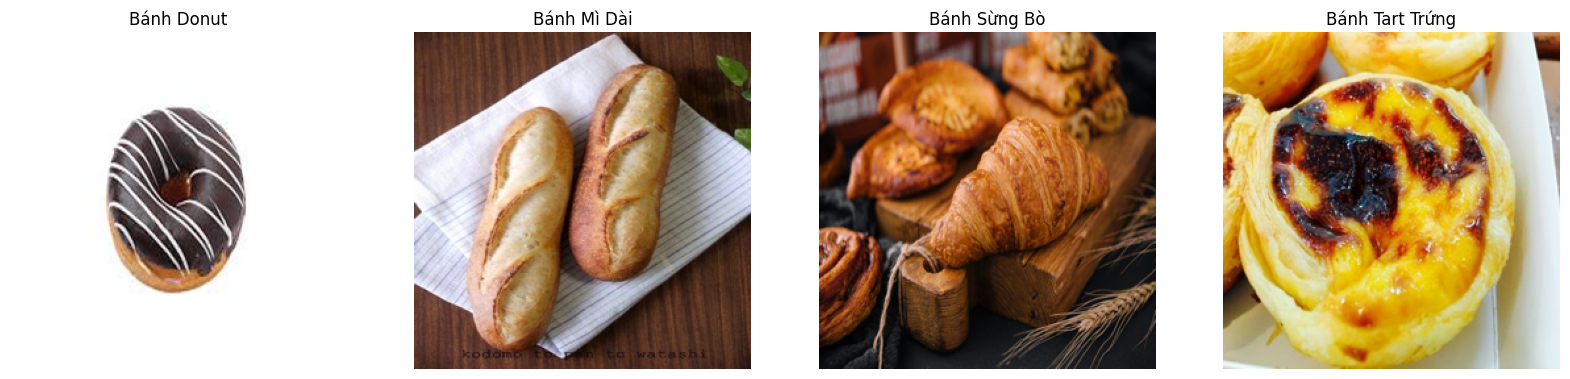

In [129]:
import os

import matplotlib.pyplot as plt

from PIL import Image



data_dir_train = "/kaggle/input/breadimagedata/BreadImage/train" # đường dẫn tới tập train

data_dir_test = "/kaggle/input/breadimagedata/BreadImage/test" # đường dẫn tới tập test



#Các loại bánh mì

bread_types = ['Bánh Donut', 'Bánh Mì Dài', 'Bánh Sừng Bò', 'Bánh Tart Trứng']

#In ra số lượng ảnh bánh mì mỗi loại
def count_images(data_dir, bread_types):
    counts = {}
    for bread_type in bread_types:
        folder_path = os.path.join(data_dir, bread_type)
        if os.path.exists(folder_path):
            images = os.listdir(folder_path)
            counts[bread_type] = len(images)
        else:
            counts[bread_type] = 0
    return counts
# Đếm số lượng ảnh trong tập train và tập test
train_counts = count_images(data_dir_train, bread_types)
test_counts = count_images(data_dir_test, bread_types)

print("Số lượng ảnh trong tập train:", sum(train_counts.values()))
for bread_type in bread_types:
    print(f"{bread_type} có {train_counts[bread_type]} ảnh")
print("--------------------------------------------")
print("Số lượng ảnh trong tập test:", sum(test_counts.values()))
for bread_type in bread_types:
    print(f"{bread_type} có {test_counts[bread_type]} ảnh")
# Hiển thị các loại bánh mì

def show_images(data_dir, bread_types):

    plt.figure(figsize=(20, 15)) # tạo ra đối tượng ảnh có kích thước 20x15 pixel



    for i, bread_type in enumerate(bread_types):

        folder_path = os.path.join(data_dir, bread_type) # đường dẫn tới thư mục chứa 1 loại bánh mì

        # ex: data_dir = '/content/drive/MyDrive/BreadImage/train/'

        # bread_type = 'Bánh Donut'

        #folder_path = '/content/drive/MyDrive/BreadImage/train/Bánh Donut'



        # Lấy danh sách các ảnh trong thư mục

        images = os.listdir(folder_path) # listdir: list directory



        if images:  # Kiểm tra xem thư mục có ảnh không

            img_path = os.path.join(folder_path, images[0]) # Lấy ảnh đầu tiên

            img = Image.open(img_path) #

            img = img.resize((256, 256)) # điều chỉnh kích thước ảnh 256x256 pixel

            plt.subplot(1, 4, i+1)  # Tạo subplot cho mỗi loại bánh mì (nrow, ncol, index): tạo ra 1 hàng, 4 cột, mỗi index là 1 loại bánh mì

            plt.imshow(img) # hiển thị ảnh

            plt.title(bread_type) # hiển thị tên loại bánh mì cho ảnh

            plt.axis('off')  # Tắt trục oxy

    plt.show()

# Gọi hàm để hiển thị ảnh

show_images(data_dir_train, bread_types)

##Preprocessing Image

In [118]:
transform = transforms.Compose([

    transforms.Resize((128, 128)), #thay đổi kích thước ảnh 128x128 pixel

    transforms.RandomHorizontalFlip(p=0.5), # lật ngang hình ảnh, với xác suất 1 ảnh bị lật là p = 0.5 (50%)

    transforms.RandomRotation(5), # xoay ảnh trong khoảng (-5, 5) độ

    transforms.ToTensor(), # chuyển ảnh sang dạng tensor

    transforms.Normalize( # chuẩn hóa các giá trị pixel của hình ảnh.

        mean = [0.5, 0.5, 0.5],

        std = [0.5, 0.5, 0.5]

    ),

    transforms.RandomErasing( # xóa ngẫu nhiên 1 phần của ảnh

        p = 0.5, # xác suất 1 ảnh bị xóa 1 phần

        scale = (0.01, 0.3), # tỉ lệ 1 vùng bị xóa (từ 1 đến 30%)

        ratio = (1.0, 1.0), # tỉ lệ chiều rộng và chiều cao bị xóa (1.0, 1.0) tức vùng bị xóa là hình vuông

        value = 0, # giá trị của pixel trong vùng bị xóa, tức là vùng nào bị xóa thì pixel bị xóa đó được đặt là 0 (pixel = 0 là màu đen)

        inplace = True # thực hiện xóa trực tiếp trên ảnh, không cần tạo bản sao

    )

])

# Lấy ảnh từ thư mục đưa vào tập train và tập test

batch_size = 64

epochs = 50 # Số lần duyệt qua ảnh

train_dataset = datasets.ImageFolder(root=data_dir_train, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform)

test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [119]:
train_dataset.classes

['Bánh Donut', 'Bánh Mì Dài', 'Bánh Sừng Bò', 'Bánh Tart Trứng']

##Trainer

In [120]:
model = models.resnet18(pretrained=True) #Sử dụng model ResNet, pretrained = True: đã được train với tập dữ liệu ImageNet

num_features = model.fc.in_features # Lấy ra số lượng feature ở đầu vào của lớp fully connected

model.fc = nn.Linear(num_features, 4) # Thay đổi thông số ở lớp đầu ra của lớp fully connected

model.to(device) # Chuyển mô hình sang sử dụng gpu

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [121]:
lr = 0.001 # Learning rate: tốc độ học của mô hình

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss: hàm loss để tính toán sai số của mô hình

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005) # Adam: dùng để cập nhật trọng số của mô hình trong quá trình học

scheduler = optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = 0.98)

##Training

In [122]:
train_accuracy = [] # lưu trữ độ chính xác tập train của mô hình qua từng epoch

train_losses = [] # lưu trữ sai số tập train của mô hình qua từng epoch

test_accuracy = [] # lưu trữ độ chính xác tập test của mô hình qua từng epoch

test_losses = [] # lưu trữ sai số tập test của mô hình qua từng epoch

best_epoch = 0
best_accuracy = 0.0
for epoch in range(epochs): # thực hiện lặp qua từng epoch

    model.train() # chuyển model sang chế độ huấn luyện

    train_cor = 0 # lưu trữ số dự đoán đúng trong 1 epoch

    train_total = 0 # lưu trữ số mẫu trong 1 epoch

    train_loss = [] # lưu trữ sai số trong 1 epoch

    for inputs, labels in train_loader: #inputs: ảnh, labels: nhãn

        inputs, labels = inputs.to(device), labels.to(device) # Chuyển ảnh và nhãn sang gpu để huấn luyện

        optimizer.zero_grad() # Đặt đạo hàm bằng 0

        predictions = model(inputs) # Dự đoán của mô hình từ inputs đầu vào

        loss = criterion(predictions, labels) # Tính toán sai số của mô hình

        train_loss.append(loss.item()) # Lưu sai số vào danh sách train_loss

        loss.backward() # Tính toán đạo hàm

        optimizer.step() # Cập nhật trọng số

        train_cor += (predictions.argmax(1) == labels).sum().item() #Tính số dự đoán đúng

        train_total += predictions.size(0) # Tính toán số mẫu dữ liệu

    train_accuracy.append(train_cor / train_total) # tính độ chính xác của một epoch và lưu vào danh sách train_accuracy

    train_losses.append(sum(train_loss) / len(train_loss)) # tính sai số trung bình của một epoch và lưu vào danh sách train_losses



    model.eval() # Chuyển model sang chế độ đánh giá

    test_cor = 0

    test_total = 0

    test_loss = []

    with torch.no_grad(): # Tắt tính toán đạo hàm

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs) # Dự đoán của mô hình từ inputs

            loss = criterion(predictions, labels) # Tính toán sai số

            test_loss.append(loss.item()) # Lưu sai số vào danh sách test_loss

            test_cor += (predictions.argmax(1) == labels).sum().item() # Tính số dự đoán đúng

            test_total += predictions.size(0) # Tính toán số mẫu dữ liệu

        test_accuracy.append(test_cor/test_total) # tính độ chính xác của một epoch và lưu vào danh sách test_accuracy

        test_losses.append(sum(test_loss)/ len(test_loss)) # tính sai số trung bình của một epoch và lưu vào danh sáchtest_losses
    test_acc = test_cor / test_total
    if test_acc > best_accuracy: 
        best_accuracy = test_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
        }, 'best_model.pth')
    scheduler.step()

    #Hiển thị ra độ chính xác và sai số cho từng epoch

    print("Epoch {:3d} | Train Accuracy {:.4f} | Train Loss {:.4f} | Test Accuracy {:.4f} | Test Loss {:.4f}".format(epoch+1, train_cor / train_total, sum(train_loss)/ len(train_loss), test_cor / test_total, sum(test_loss)/ len(test_loss)))


Epoch   1 | Train Accuracy 0.7110 | Train Loss 0.6899 | Test Accuracy 0.3370 | Test Loss 14.9063
Epoch   2 | Train Accuracy 0.8725 | Train Loss 0.3876 | Test Accuracy 0.6304 | Test Loss 4.2511
Epoch   3 | Train Accuracy 0.9263 | Train Loss 0.2360 | Test Accuracy 0.8370 | Test Loss 1.1376
Epoch   4 | Train Accuracy 0.9348 | Train Loss 0.2442 | Test Accuracy 0.7826 | Test Loss 2.5269
Epoch   5 | Train Accuracy 0.9292 | Train Loss 0.1980 | Test Accuracy 0.9348 | Test Loss 0.5034
Epoch   6 | Train Accuracy 0.9462 | Train Loss 0.1610 | Test Accuracy 0.7826 | Test Loss 1.5024
Epoch   7 | Train Accuracy 0.9632 | Train Loss 0.1334 | Test Accuracy 0.9130 | Test Loss 0.2601
Epoch   8 | Train Accuracy 0.9830 | Train Loss 0.0629 | Test Accuracy 0.9022 | Test Loss 0.3441
Epoch   9 | Train Accuracy 0.9717 | Train Loss 0.0800 | Test Accuracy 0.7609 | Test Loss 0.8377
Epoch  10 | Train Accuracy 0.9830 | Train Loss 0.0536 | Test Accuracy 0.8696 | Test Loss 0.3640
Epoch  11 | Train Accuracy 0.9717 | Tra

In [126]:
# Tải lại model có khả năng dự đoán cao nhất
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
best_accuracy = checkpoint['best_accuracy']
print("Best accuracy for test data is {:.4f}".format(best_accuracy))

Best accuracy for test data is 0.9891


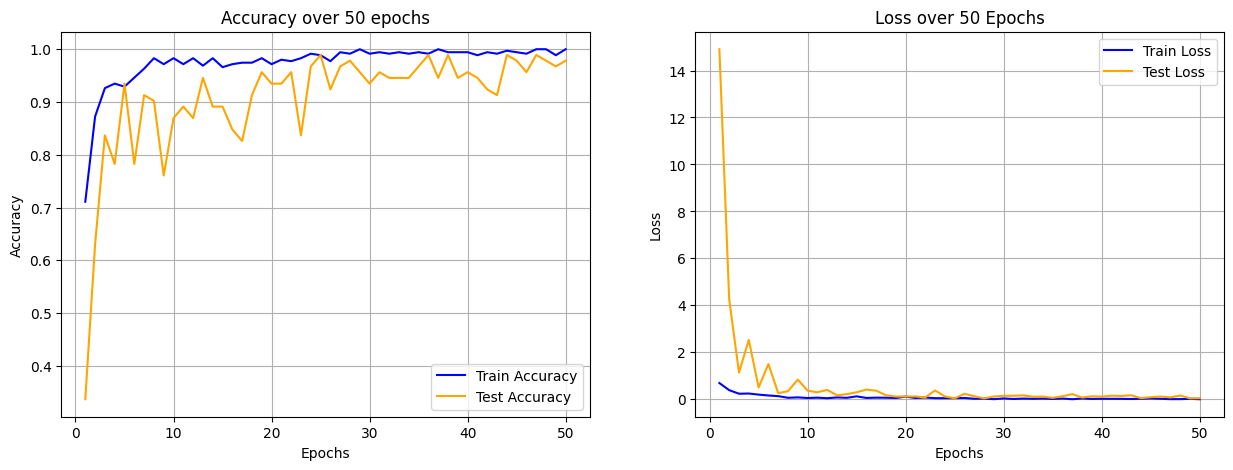

In [127]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracy, label = 'Train Accuracy', color = 'blue')
plt.plot(range(1, epochs+1), test_accuracy, label = 'Test Accuracy', color = 'orange')
plt.title('Accuracy over 50 epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='orange')
plt.title('Loss over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

##Calculate price for bread invoice


In [ ]:
import numpy as np

from google.colab import files



# Các loại bánh mì và giá

bread_types = ['Bánh Donut', 'Bánh Mì Dài', 'Bánh Sừng Bò', 'Bánh Tart Trứng']

price = [15000, 12000, 25000, 16000]  # Giá tương ứng với các loại bánh mì



def predict_image(image_path, model):

    # Đọc ảnh và chuyển đổi

    img = Image.open(image_path).convert('RGB')

    img_tensor = transform(img).unsqueeze(0)  # Thêm chiều batch

    img_tensor = img_tensor.to(device)

    # Dự đoán

    with torch.no_grad():

        model.eval()

        model.to(device)

        prediction = model(img_tensor)

        predicted_class_index = torch.argmax(prediction, dim=1).item()



    predicted_class_name = bread_types[predicted_class_index]

    predicted_class_price = price[predicted_class_index]



    # Hiển thị ảnh và kết quả dự đoán

    plt.imshow(img)

    plt.title(f"Dự đoán: {predicted_class_name}\nGiá: {predicted_class_price} VND")

    plt.axis('off')

    plt.show()



    return predicted_class_name, predicted_class_price



def upload_and_predict(model):

    total_price = 0



    print("Vui lòng tải ảnh lên (bạn có thể chọn nhiều ảnh).")

    uploaded_files = files.upload()



    if not uploaded_files:

        print("Không có ảnh nào được tải lên. Vui lòng thử lại!")

        return



    for file_name, file_content in uploaded_files.items():

        with open(file_name, "wb") as f:

            f.write(file_content)



        try:

            predicted_class_name, predicted_class_price = predict_image(file_name, model)

            print(f"Ảnh: {file_name}")

            print(f"Dự đoán: {predicted_class_name}")

            print(f"Giá: {predicted_class_price} VND\n")



            total_price += predicted_class_price

        except Exception as e:

            print(f"Lỗi khi dự đoán ảnh {file_name}: {e}")



    print(f"Tổng số tiền cần trả: {total_price} VND")

upload_and_predict(model)